In [1]:
from math import e, factorial,log, gamma, sqrt, floor
from matplotlib import pyplot as pt
from numpy.random import geometric,exponential,poisson
from scipy.stats import ks_2samp
from scipy.stats import norm
from numpy import linspace
from IPython.display import Markdown
from analysis import *

# Load data

This is a comment


In [2]:
f1 = open("r0-d0-result.txt")
raw1 = f1.read()
f1.close()

f2 = open("r0-d1-result.txt")
raw2 = f2.read()
f2.close()

f3 = open("r3-d0-result.txt")
raw3 = f3.read()
f3.close()

f4 = open("r3-d1-result.txt")
raw4 = f4.read()
f4.close()

f5 = open("r5-d0-result.txt")
raw5 = f5.read()
f5.close()

f6 = open("r5-d1-result.txt")
raw6 = f6.read()
f6.close()

f7 = open("r7-d0-result.txt")
raw7 = f7.read()
f7.close()

f8 = open("r7-d1-result.txt")
raw8 = f8.read()
f8.close()


In [3]:
Ttx = 23
Trx = 60
Tn = 100
    
def compute_histogram(r1,r2):

    Eb1,Es1,En1 = computeEvents(r1,Ttx,Trx,Tn)
    Eb2,Es2,En2 = computeEvents(r2,Ttx,Trx,Tn)
    display(Markdown('<span style="color: #af0000">'+"P(S) = %.6f"%(Trx*Es1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #00af00">'+"P(N) = %.6f"%(Tn*En1/len(r1))+'</span>'))
    display(Markdown('<span style="color: #0000af">'+"P(B) = %.6f"%(Ttx*Eb1/len(r1))+'</span>'))

    Pb2 = Eb2*Ttx/(Eb2*Ttx+En2*Tn+Es2*Trx)
    rt1 = Pb2/(Ttx/1000)
    print("r(B)(Events/s) = %.6f"%(rt1))
    
    hist1 = genWindowHistogram(r1,r2,1000,Eb2)
    Esuc = checkSuccess(r2,r1)
    Ps=Esuc/Eb2
    print(Eb2)
    print(Esuc)
    print(Eb2/Esuc)
    Ns = Ps*1000/Ttx
    Nb = rt1*1000
    print("Success probability evts: %.6f"%(Ps))
    return hist1,Eb1,Es1,En1,Ps

In [4]:
hist1,Eb1,Es1,En1,Ps1 = compute_histogram(raw1,raw2)
print(1-hist1[0])
print('---------------------')
hist2,Eb2,Es2,En2,Ps2 = compute_histogram(raw3,raw4)
print(1-hist2[0])
print('---------------------')
hist3,Eb3,Es3,En3,Ps3 = compute_histogram(raw5,raw6)
print(1-hist3[0])
print('---------------------')
hist4,Eb4,Es4,En4,Ps4 = compute_histogram(raw7,raw8)
print(1-hist4[0])
print('---------------------')

<span style="color: #af0000">P(S) = 0.722629</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.277371</span>

r(B)(Events/s) = 12.023717
1.0000000000000002
499297
360573
1.3847320792183553
Success probability evts: 0.722161
0.9996384496721944
---------------------


<span style="color: #af0000">P(S) = 0.301436</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.698564</span>

r(B)(Events/s) = 30.442189
1.0
858994
258553
3.3223130267295296
Success probability evts: 0.300995
0.9955401387512388
---------------------


<span style="color: #af0000">P(S) = 0.500006</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.499994</span>

r(B)(Events/s) = 21.762226
1.0
723317
361625
2.0001852748012445
Success probability evts: 0.499954
0.9993384254525771
---------------------


<span style="color: #af0000">P(S) = 0.700464</span>

<span style="color: #00af00">P(N) = 0.000000</span>

<span style="color: #0000af">P(B) = 0.299536</span>

r(B)(Events/s) = 13.030432
1.0
527503
368913
1.4298845527265236
Success probability evts: 0.699357
0.9996295381575697
---------------------


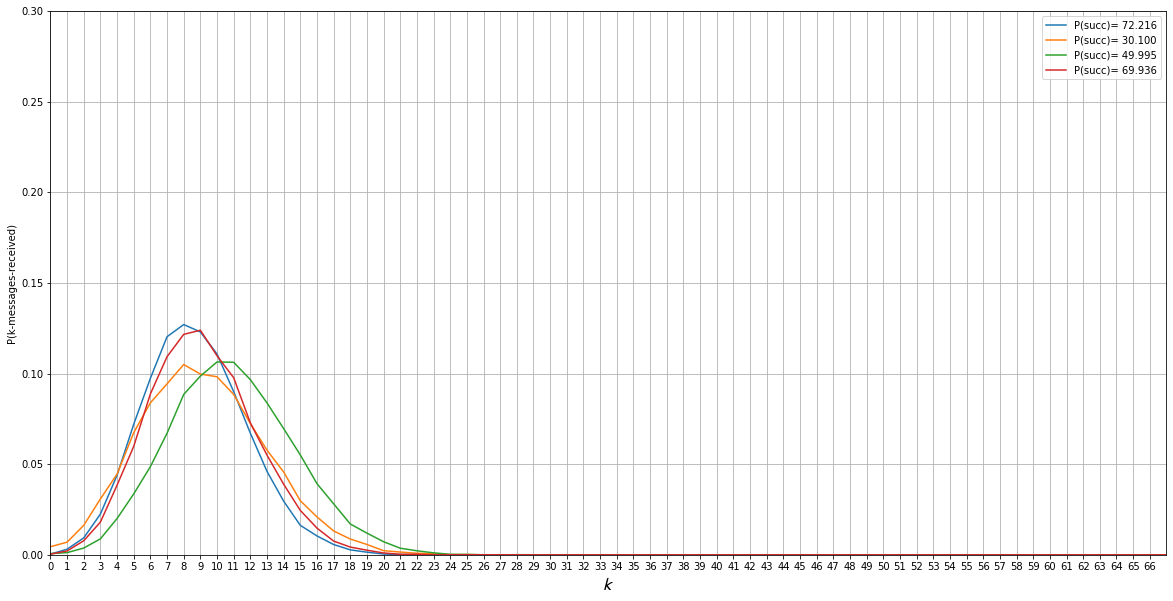

In [5]:
pt.rcParams["figure.figsize"] = (20,10)
pt.plot(range(len(hist1)),hist1,label="P(succ)= %.3f"%(100*Ps1))
pt.plot(range(len(hist2)),hist2,label="P(succ)= %.3f"%(100*Ps2))
pt.plot(range(len(hist3)),hist3,label="P(succ)= %.3f"%(100*Ps3))
pt.plot(range(len(hist4)),hist4,label="P(succ)= %.3f"%(100*Ps4))

pt.legend()
pt.axis([0,67,0,0.3])
pt.xticks(range(67), [str(n) for n in range(67)])
pt.xlabel(r'$\mathcal{k}$', fontsize = 18)
pt.ylabel(r'P(k-messages-received)')
pt.savefig('test.svg',format='svg',dpi=300, bbox_inches='tight')
pt.grid(True)
pt.show()